#First MLJC meeting: introduction to EEG processing through MNE
This tutorial wants to be a friendly introduction to the basics of MNE, as a result of what we learnt struggling with it for some time.

It's kind of a "work-in-progress" in the sense that the better we get know how to handle this library, the more the tutorial will be detailed. 

Please note that many advantages of MNE come from the interactiveness of plots, that can be achieved only running this code in a Python script and not on a Colab Notebook (navigating signals, annotating and dropping bad channels/epochs, indentifying channel lines in PSD plots, ecc.). You can obtain a `.py` file clicking on `File/Download/Download .py`. Just pay attention to the warning related to Colab related artifacts (paths, packages installations) and the fact that when the `.py` is completely executed all figures are shut down. For the moment we will upload a ready to use `.py` file that you have to execute in a folder containing a subfolder called `BCICIV_1_mat` containing the dataset (obv after installing MNE on your terminal).   

If you get to dig deeper than us and find out errors, misunderstandings or possible improvements of the processes, please get in touch and collaborate for the greater good (we are no masters or teachers).

<br>

The aim of doing all of this is providing you with a more basic and general approach, and also make you feel closer to who can help you in finding answers to your doubts. Then feel free to get in touch on the association telegram group or direct messages (@dawesp, @gabrielepenna, @Japsleglock). 

<br>

Data used in this tutorial come from [BCI Competition IV](https://www.bbci.de/competition/iv/).

Click [here](https://www.bbci.de/competition/iv/download/index.html?agree=yes&submit=Submit) for more downloadable content and related docs.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing .mat files
A `.mat` file is imported by `scipy.io.loadmat(<path>)` as a dictionary with one different field for each variable saved inside the `.mat` file. 

![dati_mat.png](https://drive.google.com/uc?id=1Ruopg55xuwm1pmT7RJ7oonZkQXt2dRaC "Matlab workspace view")

In [ ]:
import scipy.io as spio
curr_dir = "/content/drive/MyDrive/Lesson_1_MLJC/"
dati_mat = spio.loadmat(f"{curr_dir}BCICIV_calib_ds1a.mat")
print(dati_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])


In [ ]:
eeg = dati_mat['cnt']

print("cnt type: ", eeg.dtype)
print("cnt shape: ", eeg.shape)

cnt type:  int16
cnt shape:  (190594, 59)


In [ ]:
nfo = dati_mat['nfo']
print("nfo shape: ", nfo.shape)

# A matlab struct is here rapresented as a 1x1 ndarray! 
# It seems very different from what we get in matlab, but if we see what's 
# in nfo.dtype we find out theres something similar to the matlab struct fields
print("nfo.dtype: ", nfo.dtype)

# We can call each field as if it was a dict, and the values of this dict are
# always 1x1 arrays: that's why we extract dict[<key>][0,0]
fs = int(nfo['fs'])
classes = nfo['classes'][0,0]
clab = nfo['clab'][0,0]
xpos = nfo['xpos'][0,0]
ypos = nfo['ypos'][0,0]

nfo shape:  (1, 1)
nfo.dtype:  [('fs', 'O'), ('classes', 'O'), ('clab', 'O'), ('xpos', 'O'), ('ypos', 'O')]


![mrk](https://drive.google.com/uc?id=1Xy9QS5L2Vhjimpo320dDT2URZZuqX1pz)


In [ ]:
# Same can be done with mrk
mrk = dati_mat['mrk']
print("mrk shape: ", mrk.shape)
print("mrk.dtype: ", mrk.dtype)

pos = mrk['pos'][0,0]
y = mrk['y'][0,0]

mrk shape:  (1, 1)
mrk.dtype:  [('pos', 'O'), ('y', 'O')]


![mrk](https://drive.google.com/uc?id=1_iKsavorwsK9HtiSW9OVtvZBTPIT3kWW)

# Signals handling
General processing utilities can be found in packages like [SciPy](https://docs.scipy.org/doc/scipy/reference/index.html), which manipulates signals in form of NumPy arrays, but some libraries exist for specific applications such as neuroimaging signals applications: an example is [MNE](https://mne.tools/stable/python_reference.html). 

MNE manipulates signals as objects, not as simple arrays: this makes it a little more tricky to set your dataset up, but helps a lot when it's time to plot and process data.


In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Let's bring channels labels to a more friendly list of strings
chs = [c[0] for c in clab[0,:]]

# Creation of a [Raw](https://mne.tools/stable/generated/mne.io.Raw.html) object from data in a numpy array (with [mne.io.RawArray](/https://mne.tools/stable/generated/mne.io.RawArray.html))
Here we also plot the data: remember the arguments always useful to avoid misrepresentations
- `block=True` to actually be able to see the plot (in a normal python script)
- `cliiping=None` to avoid cuts on signal traces on the y axis
- `scalings=100e-6` to be sure to see the entire traces: it means that the half width of the channel space in the plot will be 100 μV


Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


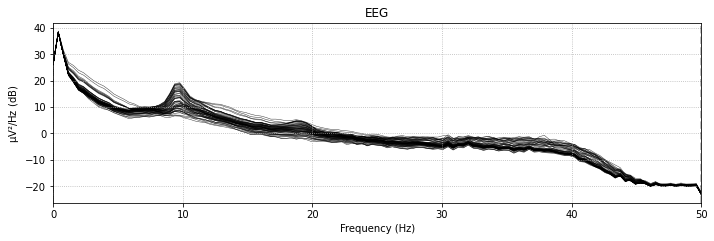

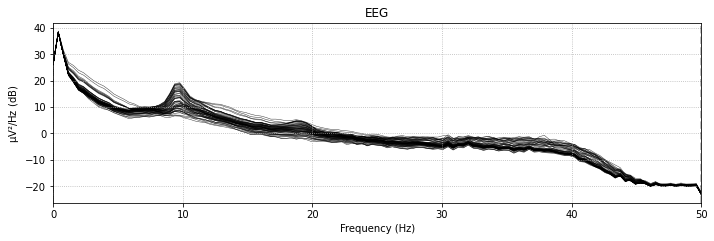

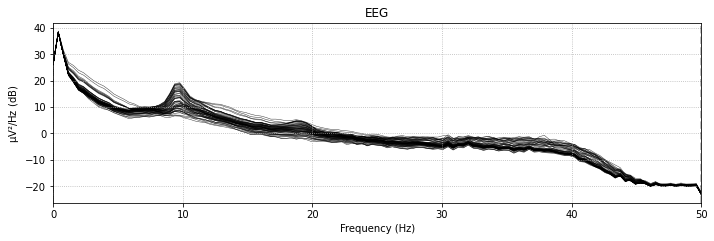

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


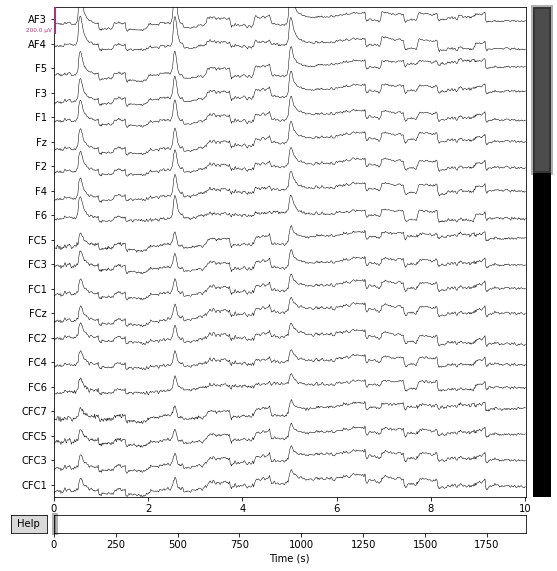

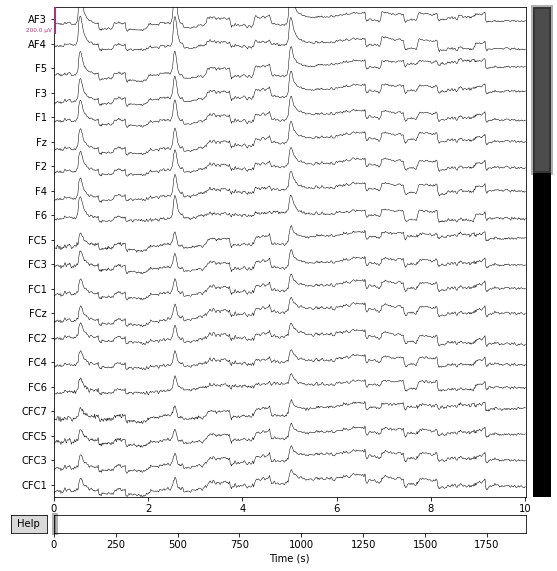

In [ ]:
from mne.io import RawArray
from mne import create_info

# RawArray wants a channel each row of the numpy array and the traces in volts
# Accordingly to the information attached to the dataset (https://www.bbci.de/competition/iv/desc_1.html)
# the unit of the traces here is 0.1 microV, then we have to divide the original data by 10^7
thisRec = RawArray(eeg.T/1e7, create_info(chs, fs, ch_types='eeg'))
thisRec.plot(block=True, clipping=None, scalings=100e-6)

Usually EEG signals have to be filtered to remove slow drifts (low frequencies components) and power line interference noise (50 Hz in Europe, 60 Hz in USA), and finally to isolate the informative content of the signal (usually not more than 45 Hz, due to the low-pass behaviour of scalp anf tissues that the signal has to pass through).

To reach these objectives, the common solution is to use an high-pass filter (HPF) with cut-off frequency (fc) at 0.5 Hz, a band-stop filter, aka *notch filter*, centered at the power-line frequency, and a low-pass filter (LPF) with fc=40 Hz. (yep, if we cut this low with the LPF, the notch is not necessary, but just for you to know, with any other signal, if your interested in higher frequencies, don't ever forget to cut off the power-line noise)  

As we can see from the dataset docs, this signal is already filtered between .5 and 49 Hz, so filtering with the objective of cleaning the signals up is not necessary. But we can use a band-pass filter (BPF) also to isolate some frequency components and visualize them in time, or compute their power without wasting time on all the others.

Let's assume we want to plot the alpha component (8-13 Hz) in time domain, thats how we do it.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    1.0s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


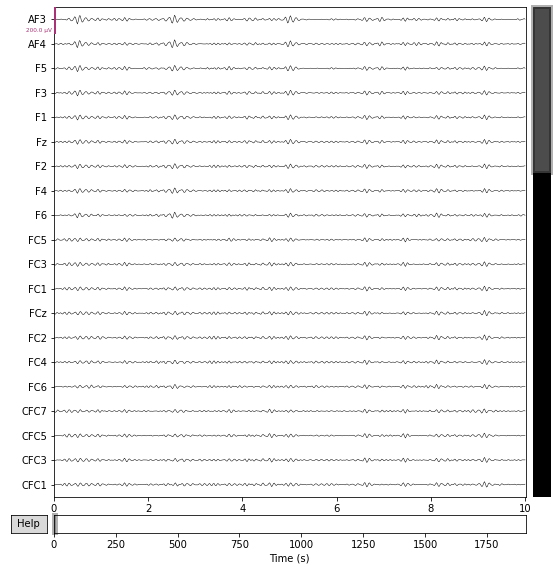

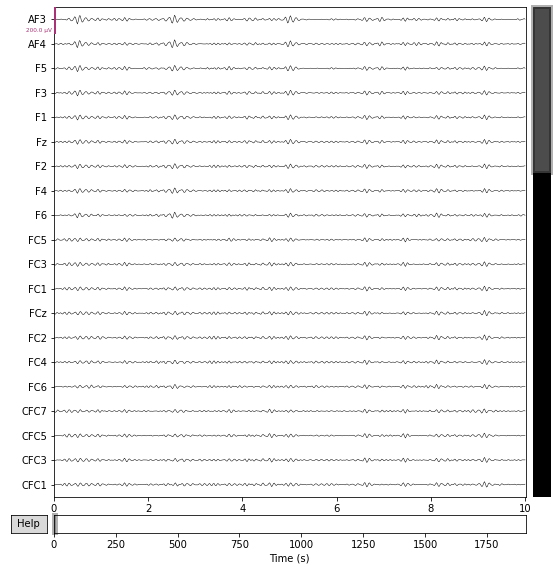

In [ ]:
temp = thisRec.copy() # the method filters the signal in-place, so this time I 
                      # want to preserve the orignial signal and filter just a 
                      # temporary copy of it


temp.filter(8,13) # easy huh?!
temp.plot(block=True, clipping=None, scalings=100e-6)

# Clearly digging into MNE documentation and digital filters theory, you can 
# discover that many different filtering methods can be used, different orders 
# can be chosen, all of this to tune the processing to your specific necessities.
# Arguments can be passed to the .filter() method to alter the default settings. 

#PSD computation
An useful instrument to inspect frequency domain information is the power spectral density estime (PSD), and MNE takes care of all the theoretical warning points that have to be addressed before its computation: it can be obtained and plotted simply like this.

Effective window size : 2.560 (s)


<ipython-input-41-c5de9a7ebe09>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  Pxx.plot()


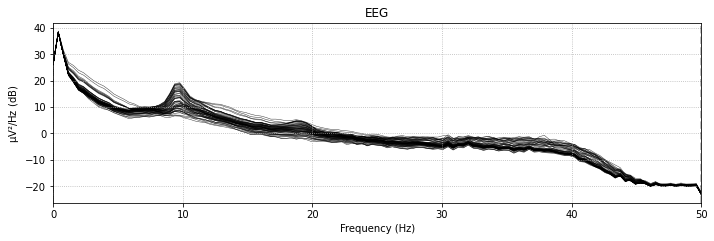

In [ ]:
Pxx = thisRec.compute_psd()
Pxx.plot()

The result is a [Spectrum object](https://mne.tools/stable/generated/mne.time_frequency.Spectrum.html)

In [ ]:
Pxx

Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,59
Number of frequency bins,129
Frequency range,0.00 – 50.00 Hz


# Creation of an [Epochs](https://mne.tools/stable/generated/mne.Epochs.html) object from Raw and [events](https://mne.tools/stable/generated/mne.find_events.html#mne.find_events)

Usually EEG data (to be used as part of a training dataset) is acquired in the context of an experimental protocol, consisting of visual/auditory cues which can trigger event related potentials (ERP) or tell the subject when to start with the endogenous oscillatory process (such as in motor imagery protocols).

We can use this cues to epoch the signal and extract specific features related to the mental state of the subject around those particular time points.

In this dataset we have two motor imagery (MI) classes and then two different cues associated to two different labels: -1 and 1. 

To obtain an Epochs object we need some ingredients:
- the Raw object containing EEG data, `thisRec`
- an array containing the labels fro each time stamp, `stim_data`

These ingredients must be manipulated first to get a Raw object complete of a *stimuli* channel, second to get the events array from it, third to finally obtain the Epochs object.

Creating RawArray with float64 data, n_channels=1, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
200 events found
Event IDs: [1 3]


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


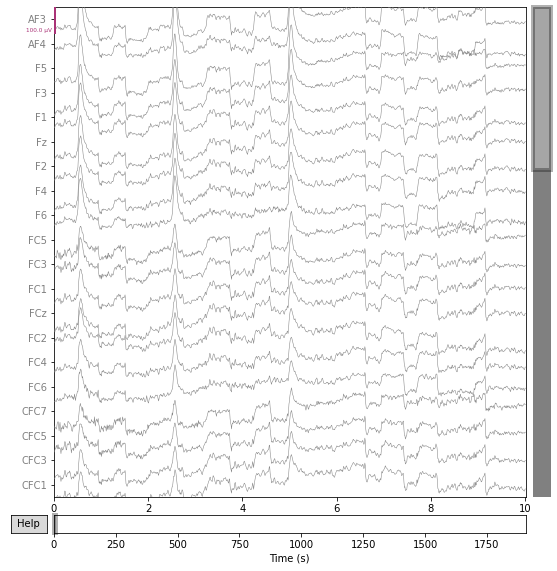

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 251 original time points ...
0 bad epochs dropped


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


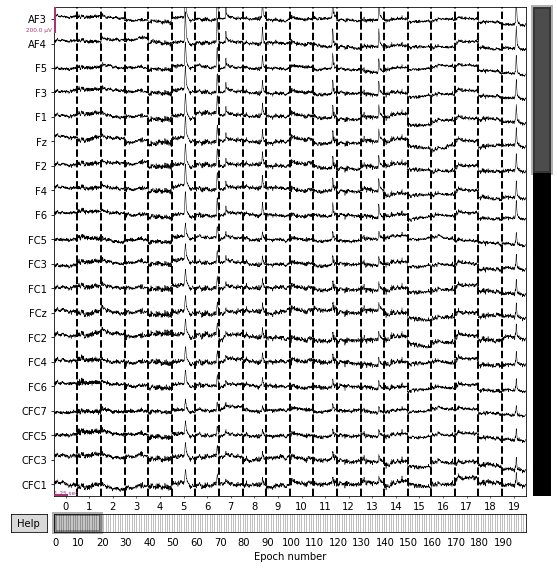

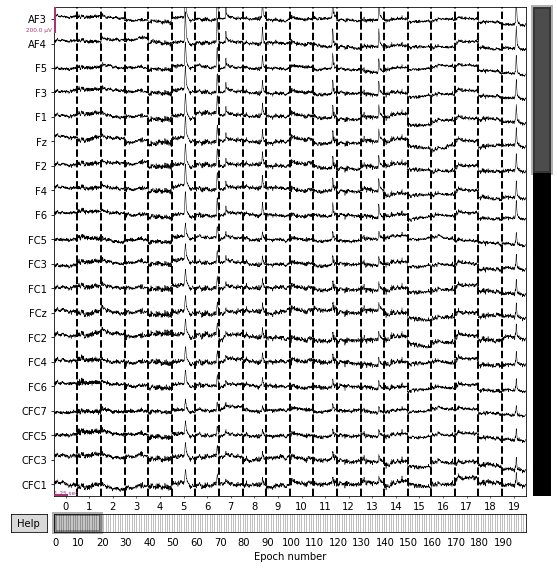

In [ ]:
from numpy import zeros
from mne import find_events

# Create the stimuli channel 
stim_data = zeros((1,thisRec.n_times))

# MNE works with absolute values of labels so -1 and +1 would result in only one kind of event
# that's why we add 2 and obtain 1 and 3 as label values
stim_data[0,pos] = y+2
stim_raw = RawArray(stim_data, create_info(['STI'], thisRec.info['sfreq'], ch_types=['stim']))

# adding the stimuli channel (as a Raw object) to our EEG Raw object
thisRec.add_channels([stim_raw])

# extracting events from the stimuli channel and giving thema a class name with the dict ev_ids
evs = find_events(thisRec, stim_channel='STI')
ev_ids = {'Class one': 1, 'Class two': 3}

# Easily visualize events along the signal plot
thisRec.plot(events = evs, event_id = ev_ids, event_color ={1:'g',3:'r'}, color = 'Gray',
             block = True, clipping=None, scalings=50e-6)

# creating the Epochs object combining EEG data and events info
from mne import Epochs
eps = Epochs(thisRec, evs, event_id=ev_ids, 
             tmin=0, tmax=2.5, baseline=(0,.5)) 
            # This last parameters define the time window extracted as single epoch relatively to
            # the single event, 'baseline' is the timespan from which the data for the baseline 
            # correction is extracted.
            # In this case the epoch starts at the event and ends 2.5 s after, and the baseline 
            # corresponds to the first 0.5 s of the epoch

eps.plot(block=True, scalings=100e-6) # .plot() method for Epoch objects has not clipping parameter

CLASS ONE EPOCHS PSD
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


<ipython-input-64-9e57b0f1b546>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eps['Class one'].compute_psd().plot()


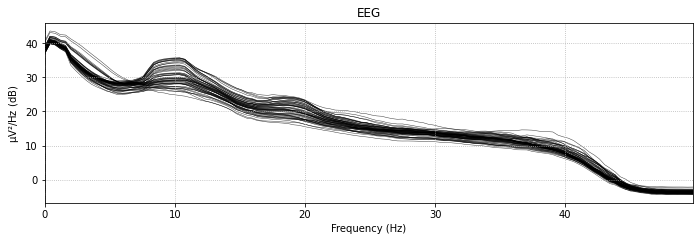

In [ ]:
print("CLASS ONE EPOCHS PSD")
eps['Class one'].compute_psd().plot()

CLASS TWO EPOCHS PSD
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


<ipython-input-66-e25b0a3bf3ff>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eps['Class two'].compute_psd().plot()


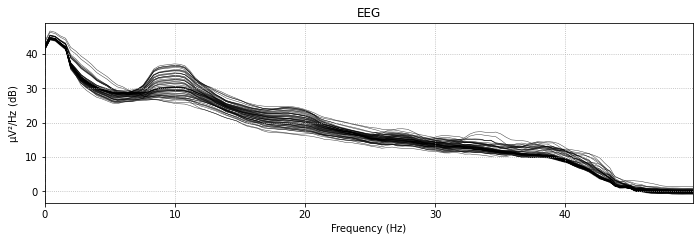

In [ ]:
print("CLASS TWO EPOCHS PSD")
eps['Class two'].compute_psd().plot()